# VAE

In [1]:
USE_SERVER = True
if USE_SERVER:
    !pip install elasticsearch
    !pip install elasticsearch_dsl
    !pip install pymed
    !pip install gensim
    !pip install torchsummary

  Using cached elasticsearch-7.8.0-py2.py3-none-any.whl (188 kB)
  Using cached elasticsearch_dsl-7.2.1-py2.py3-none-any.whl (53 kB)
  Using cached pymed-0.8.9-py3-none-any.whl (9.6 kB)
  Using cached gensim-3.8.3-cp36-cp36m-manylinux1_x86_64.whl (24.2 MB)
Processing /home/ubuntu/.cache/pip/wheels/a4/9b/d5/85705a7ab783cd6f7bd718f01d3b1396272f30044e3c36401a/smart_open-2.1.0-py3-none-any.whl
  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [344]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import utils
import os
from utils import PROJECT_ROOT, DATA_PATH
import yuval_module.paper_source as PaperSource

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

import py_4.get_mesh_vec as get_mesh_vec
import py_3.sim_matrix_3 as sim_matrix_3
import py_4.get_all_features as get_all_features 

from torch.utils.data import Dataset, DataLoader

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
mesh_embed=get_mesh_vec.MeshEmbeddings(PROJECT_ROOT + "data/mesh_data/MeSHFeatureGeneratedByDeepWalk.csv")

In [6]:
FILE = "enriched_labeled_dataset_large" 
if os.path.exists(PROJECT_ROOT + DATA_PATH + FILE):
    print("READING FROM LOCAL")
    if FILE.split(".")[1] == "json":
        df = pd.read_json(PROJECT_ROOT + DATA_PATH + FILE)
    else:
        df = pd.read_csv(PROJECT_ROOT + DATA_PATH + FILE)
    #ps = PaperSource()
else:
    print("PULLING FROM S3")
    ps = sim_matrix_3.load_dataset(FILE)
    df = ps.get_dataset()

df.drop(columns=["last_author_country"],inplace=True)
df.rename(columns={'ORG_STATE':'last_author_country'},inplace=True)

print("FILE PULLED")

PULLING FROM S3
FILE PULLED


### Run VAE 

In [7]:
cd ..

/home/ubuntu/AYP_b


In [312]:
auth_core = pd.read_csv("data/train_set_author_names.csv")["0"]
auth_eps = pd.read_csv("data/val_set_author_names.csv")["0"]
auth_usecase = pd.read_csv("data/test_set_author_names.csv")["0"]

In [313]:
selection_train = list(set(df['last_author_name']) - set(auth_usecase))[:4000]
selection_val = list(set(df['last_author_name']) - set(auth_usecase))[4000:5000]
selection_test = list(set(df['last_author_name']) - set(auth_usecase))[5000:6000]

In [314]:
#settings

BATCH_SIZE= 32
EPOCHS = 30
cuda = torch.cuda.is_available()
seed = 42
log_interval = 10
num_workers = 2

#check for cuda
device = torch.device('cuda' if cuda else 'cpu')

torch.manual_seed(seed)
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

device

device(type='cuda')

In [315]:
all_vae = get_all_features.VAE_Features(df)

'/home/ubuntu/AYP/code/models/names_epochs_2_vectorSize_64_window_2.model' already exits. Using existing model to re-generate results.
'/home/ubuntu/AYP/code/models/co_authors_epochs_2_vectorSize_64_window_2.model' already exits. Using existing model to re-generate results.


In [316]:
df_nonan = df[np.invert(df['mesh'].isna())]

In [317]:
class ToyDS(Dataset):
    def __init__(self,df,selection,vae_features = None):
        super().__init__()
        self.df = df[df['last_author_name'].isin(selection)]
        if vae_features is None:
            print("Creating new VAE FEATURES")
            self.vae_features = get_all_features.VAE_Features(self.df)
        else:
            print("Using pre-defined VAE FEATURES")
            self.vae_features = vae_features
        self.features = self.vae_features.get_all_features(self.df)
        print(list(self.vae_features.mesh_features.mesh_missing))
        self.input_dim = self.vae_features.input_dims
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        features = self.features[idx]
        return features
    
    def __getvae__(self):
        return self.vae_features

In [318]:
train_set = ToyDS(df_nonan, selection_train, all_vae)
train_loader=DataLoader(dataset= train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = num_workers)

Using pre-defined VAE FEATURES


/home/ubuntu/AYP_b/code/py_4/get_all_features.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co_authors']=df.authors.apply( lambda x: [i['name'] for i in x] )


Defining new scaler
['MESH NAME NOT FOUND: Outcome and Process Assessment, Health Care', 'MESH NAME NOT FOUND: Aldehyde Dehydrogenase 1', 'MESH NAME NOT FOUND: Recognition, Psychology', 'MESH NAME NOT FOUND: Centers for Medicare and Medicaid Services, U.S.', 'MESH NAME NOT FOUND: Mitophagy', 'MESH NAME NOT FOUND: Inhibition, Psychological', 'MESH NAME NOT FOUND: Infections', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: B-Cell Lymphoma 3 Protein', "MESH NAME NOT FOUND: Practice Patterns, Nurses'", 'MESH NAME NOT FOUND: Phospholipid Hydroperoxide Glutathione Peroxidase', 'MESH NAME NOT FOUND: Outcome Assessment, Health Care', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Conditioning, Psychological', 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Early Intervention, Educational', 'MESH NAME NOT FOUND: Female', 'MESH NAME NOT FOUND: Transfer, Psychology', 'MESH NAME NOT FOUND: Copper-Transporting ATPa

In [319]:
val_set = ToyDS(df_nonan, selection_val, all_vae)
val_loader=DataLoader(dataset= val_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = num_workers)

Using pre-defined VAE FEATURES


/home/ubuntu/AYP_b/code/py_4/get_all_features.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co_authors']=df.authors.apply( lambda x: [i['name'] for i in x] )


Using old scaler
['MESH NAME NOT FOUND: Outcome and Process Assessment, Health Care', 'MESH NAME NOT FOUND: Aldehyde Dehydrogenase 1', 'MESH NAME NOT FOUND: Recognition, Psychology', 'MESH NAME NOT FOUND: Centers for Medicare and Medicaid Services, U.S.', 'MESH NAME NOT FOUND: Mitophagy', 'MESH NAME NOT FOUND: Inhibition, Psychological', 'MESH NAME NOT FOUND: Infections', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: B-Cell Lymphoma 3 Protein', "MESH NAME NOT FOUND: Practice Patterns, Nurses'", 'MESH NAME NOT FOUND: Phospholipid Hydroperoxide Glutathione Peroxidase', 'MESH NAME NOT FOUND: Outcome Assessment, Health Care', 'MESH NAME NOT FOUND: Indigenous Peoples', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Conditioning, Psychological', 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Early Intervention, Educational', 'MESH NAME NOT FOUND: Female', 'MESH NAME NOT FOUND: Transfer, Psychology', 'MESH 

In [320]:
print("The number of features in the train: ",train_set.input_dim)
print("The number of train data in the train: ",train_set.__len__())

The number of features in the train:  64
The number of train data in the train:  19418


In [321]:
print("The number of features in the val: ",val_set.input_dim)
print("The number of train data in the val: ",val_set.__len__())

The number of features in the val:  64
The number of train data in the val:  4652


In [322]:
class VAE(nn.Module):
    def __init__(self, hidden_dim1, hidden_dim2, latent_dim, input_dim = train_set.input_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hd1 = hidden_dim1
        self.hd2 = hidden_dim2
        self.latent_dim = latent_dim
        
        self.fc1 = nn.Linear(self.input_dim, self.hd1)
        self.fc2 = nn.Linear(self.hd1, self.hd2)
        self.fc31 = nn.Linear(self.hd2, self.latent_dim)
        self.fc32 = nn.Linear(self.hd2, self.latent_dim)
        self.fc4 = nn.Linear(self.latent_dim, self.hd2)
        self.fc5 = nn.Linear(self.hd2, self.hd1)
        self.fc6 = nn.Linear(self.hd1,self.input_dim)
        
        self.dropout = torch.nn.Dropout(p=0.4) 
        self.bn1 = nn.BatchNorm1d(self.hd1)
        self.bn2 = nn.BatchNorm1d(self.hd2)
        self.bn4 = nn.BatchNorm1d(self.hd2)
        self.bn5 = nn.BatchNorm1d(self.hd1)

    def encode(self, x):
        h = self.bn1(F.relu(self.dropout(self.fc1(x))))
        h1 = self.bn2(F.relu(self.dropout(self.fc2(h))))
        return self.fc31(h1), self.fc32(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        

    def decode(self, z):
        h = self.bn4(F.relu(self.dropout(self.fc4(z))))
        h1 = self.bn5(F.relu(self.dropout(self.fc5(h))))
        return self.fc6(h1)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [323]:
def loss_function(recon_x, x, mu, log_var):

#     MSE = F.l1_loss(recon_x, x.view(-1, train_set.input_dim))

#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
# #     KLD /= BATCH_SIZE * train_set.input_dim
    
# #     gamma = min(1.0,np.log(epoch+1))
#     assert(KLD >= 0)
    
    
#     batch_size = x.size()[0]
#     MSE =  F.mse_loss(recon_x, x)
    MSE = torch.mean(torch.square(recon_x - x))
#     KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    KLD_element = mu.pow(2).add_(log_var.exp()).mul_(-1).add_(1).add_(log_var)
    KLD = torch.sum(KLD_element).mul_(-0.5) / BATCH_SIZE
    if KLD < -1e-5:
        print(KLD)
    return MSE# + KLD 

In [324]:
model = VAE(hidden_dim1=32,hidden_dim2=16,latent_dim=8).to(device)
optimizer = optim.Adam(model.parameters())

In [325]:
num_batches = np.ceil(len(train_loader.dataset) / BATCH_SIZE)

In [326]:
def train_epoch(tr_loader, model, criterion, optimizer, num_epochs):
    model.train()
    train_log = []
    val_log = []

    for epoch in range(num_epochs):
        print("Started training epoch no. {}".format(epoch+1))
        train_loss= 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = criterion(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print('====> Epoch: {} Average loss: {:.8f}\n'.format(
            epoch+1, train_loss / num_batches))
        train_log.append({
            'epoch': epoch,
            'train_loss': train_loss / num_batches})
        val_loss = test_model(val_loader,model)
        print('====> Val set loss: {:.4f}'.format(val_loss))
        val_log.append(val_loss)
    return train_log, val_log

In [327]:
def test_model(test_loader, model):
    model.eval()
    num_batch_test = np.ceil(len(test_loader.dataset) / BATCH_SIZE)
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device, dtype=torch.float32)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= num_batch_test
    return test_loss


In [328]:
train_log, val_log = train_epoch(train_loader,model,loss_function,optimizer,num_epochs= 200)

Started training epoch no. 1
====> Epoch: 1 Average loss: 0.99971895

====> Val set loss: 0.8352
Started training epoch no. 2
====> Epoch: 2 Average loss: 0.75046828

====> Val set loss: 0.7448
Started training epoch no. 3
====> Epoch: 3 Average loss: 0.69895736

====> Val set loss: 0.6735
Started training epoch no. 4
====> Epoch: 4 Average loss: 0.62438457

====> Val set loss: 0.6166
Started training epoch no. 5
====> Epoch: 5 Average loss: 0.57825538

====> Val set loss: 0.5737
Started training epoch no. 6
====> Epoch: 6 Average loss: 0.54643082

====> Val set loss: 0.5575
Started training epoch no. 7
====> Epoch: 7 Average loss: 0.53077567

====> Val set loss: 0.5416
Started training epoch no. 8
====> Epoch: 8 Average loss: 0.51357095

====> Val set loss: 0.5261
Started training epoch no. 9
====> Epoch: 9 Average loss: 0.50167176

====> Val set loss: 0.5122
Started training epoch no. 10
====> Epoch: 10 Average loss: 0.48594715

====> Val set loss: 0.4981
Started training epoch no. 1

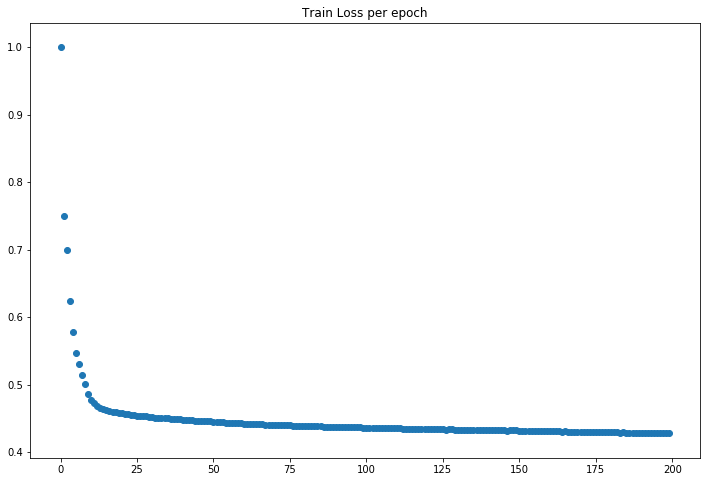

In [350]:
train_loss_plt = [x['train_loss'] for x in train_log]
plt.figure(figsize=(12,8))
plt.title("Train Loss per epoch")
plt.scatter(range(len(train_loss_plt)),train_loss_plt);

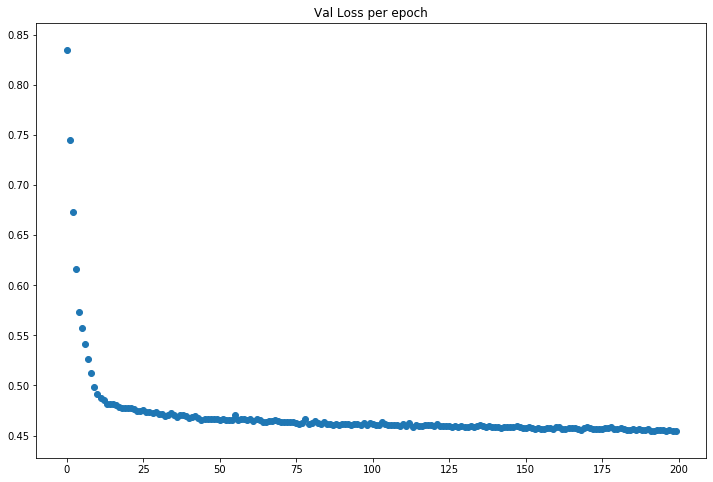

In [351]:
plt.figure(figsize=(12,8))
plt.title("Val Loss per epoch")
plt.scatter(range(len(val_log)),val_log);

### ERROR ANALYSIS

In [353]:
test_set = ToyDS(df_nonan, selection_test, all_vae)
test_loader=DataLoader(dataset= test_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = num_workers)

Using pre-defined VAE FEATURES


/home/ubuntu/AYP_b/code/py_4/get_all_features.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co_authors']=df.authors.apply( lambda x: [i['name'] for i in x] )


Using old scaler
['MESH NAME NOT FOUND: Outcome and Process Assessment, Health Care', 'MESH NAME NOT FOUND: Aldehyde Dehydrogenase 1', 'MESH NAME NOT FOUND: RNA, Circular', 'MESH NAME NOT FOUND: Recognition, Psychology', 'MESH NAME NOT FOUND: SOS Response, Genetics', 'MESH NAME NOT FOUND: Centers for Medicare and Medicaid Services, U.S.', 'MESH NAME NOT FOUND: Mitophagy', 'MESH NAME NOT FOUND: Inhibition, Psychological', 'MESH NAME NOT FOUND: Infections', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: B-Cell Lymphoma 3 Protein', "MESH NAME NOT FOUND: Practice Patterns, Nurses'", 'MESH NAME NOT FOUND: Phospholipid Hydroperoxide Glutathione Peroxidase', 'MESH NAME NOT FOUND: Outcome Assessment, Health Care', 'MESH NAME NOT FOUND: Indigenous Peoples', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Formins', 'MESH NAME NOT FOUND: Conditioning, Psychological', 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND:

In [354]:
test_model(test_loader, model)

0.4477744493881861

In [375]:
model.eval()
data = torch.from_numpy(test_set.features).to(device,dtype=torch.float32)
x_hat_test, _, __ = model(data)
x_hat = x_hat_test.detach().cpu().numpy()

In [376]:
assert(test_set.features.shape==x_hat.shape)

In [377]:
np.mean(np.square(x_hat - test_set.features))

0.4473552897901241

### Look at a few examples:

In [395]:
ind_val = 55
np.mean(np.abs(x_hat- test_set.features),axis=0)

array([0.39982909, 0.53086438, 0.45383285, 0.47972956, 0.49904886,
       0.47903072, 0.50978217, 0.45327232, 0.46838874, 0.34944014,
       0.51530886, 0.52195738, 0.49631504, 0.32495449, 0.49270349,
       0.43997057, 0.36353553, 0.49682825, 0.43845944, 0.48672176,
       0.48615264, 0.42167102, 0.46917733, 0.42132631, 0.451864  ,
       0.43044483, 0.43895675, 0.5158387 , 0.4807933 , 0.46725311,
       0.42635365, 0.35360651, 0.50975596, 0.51548551, 0.50838233,
       0.51744237, 0.48058931, 0.49735793, 0.39702019, 0.47909151,
       0.52550682, 0.40496181, 0.51892038, 0.46367968, 0.32896215,
       0.49032361, 0.48279182, 0.49473221, 0.5029582 , 0.53136885,
       0.38544666, 0.46232507, 0.39813214, 0.47074267, 0.4778636 ,
       0.41150322, 0.46070911, 0.51017423, 0.51698779, 0.42360116,
       0.42277901, 0.40536949, 0.50320037, 0.5594172 ])

In [391]:
test_set.df.iloc[55].mesh

['Animals', 'Humans']

# Test

In [153]:
selection = [auth_usecase[109]]
print(df[df['last_author_name'].isin(selection)]["PI_IDS"].value_counts())

7127687     10
10594466     8
11990780     1
Name: PI_IDS, dtype: int64


In [68]:
train_vae = train_set.__getvae__()
test_set = ToyDS(df_nonan, selection,train_vae)
test_loader=DataLoader(dataset= test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

NameError: name 'selection' is not defined

In [155]:
bottle_neck=[]
recon_batchs = []
for batch_idx, data in enumerate(test_loader):
            data = data.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            recon_batch, mu, logvar, _= model(data)
            if cuda:
                bottle_neck.extend(mu.cpu().detach().numpy())
                recon_batchs.extend(recon_batch.cpu().detach().numpy())
            else:
                bottle_neck.extend(mu.detach().numpy())
                recon_batchs.extend(recon_batch.detach().numpy())
bottle_neck = np.array(bottle_neck)
recon_batchs = np.array(recon_batchs)
print(bottle_neck.shape)
print(recon_batchs.shape)

(19, 32)
(19, 64)


In [157]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=1, n_iter=1000,random_state=42)
tsne_results = tsne.fit_transform(bottle_neck)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.634541
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.133377
[t-SNE] KL divergence after 1000 iterations: 0.337330
t-SNE done! Time elapsed: 0.14081168174743652 seconds


In [158]:
df_subset=pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

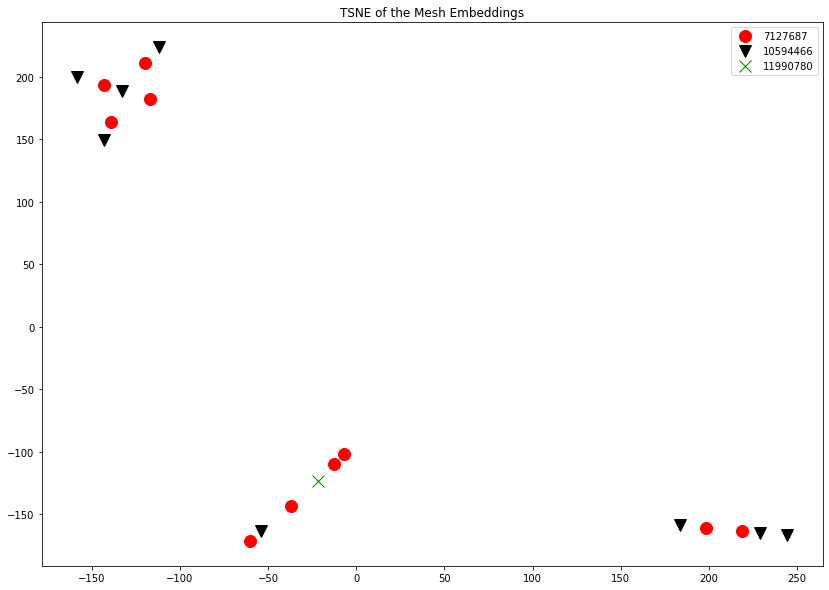

In [159]:
groups = df_subset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

### SANITY TESTS

#### ON INPUT DIM:

In [160]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=1000, random_state=42)
tsne_inputs = tsne.fit_transform(test_set.features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
input_testset=pd.DataFrame()
input_testset['tsne-2d-one'] = tsne_inputs[:,0]
input_testset['tsne-2d-two'] = tsne_inputs[:,1]
input_testset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.712021
[t-SNE] KL divergence after 1000 iterations: 0.240680
t-SNE done! Time elapsed: 0.14115023612976074 seconds


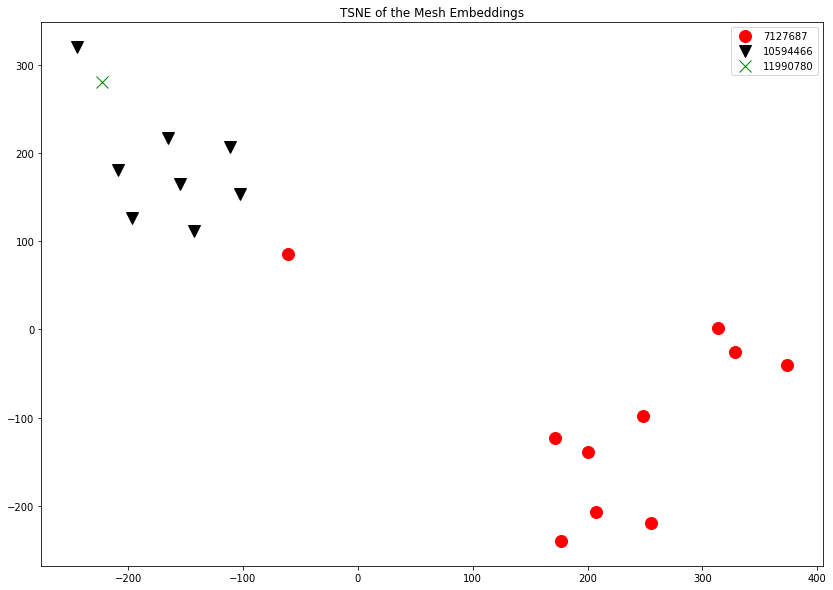

In [161]:
groups = input_testset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

### OUTPUT DIMS

In [162]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=1000,random_state=42)
tsne_output = tsne.fit_transform(recon_batchs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
output_testset=pd.DataFrame()
output_testset['tsne-2d-one'] = tsne_output[:,0]
output_testset['tsne-2d-two'] = tsne_output[:,1]
output_testset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.000622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.051392
[t-SNE] KL divergence after 1000 iterations: 0.264274
t-SNE done! Time elapsed: 0.14203095436096191 seconds


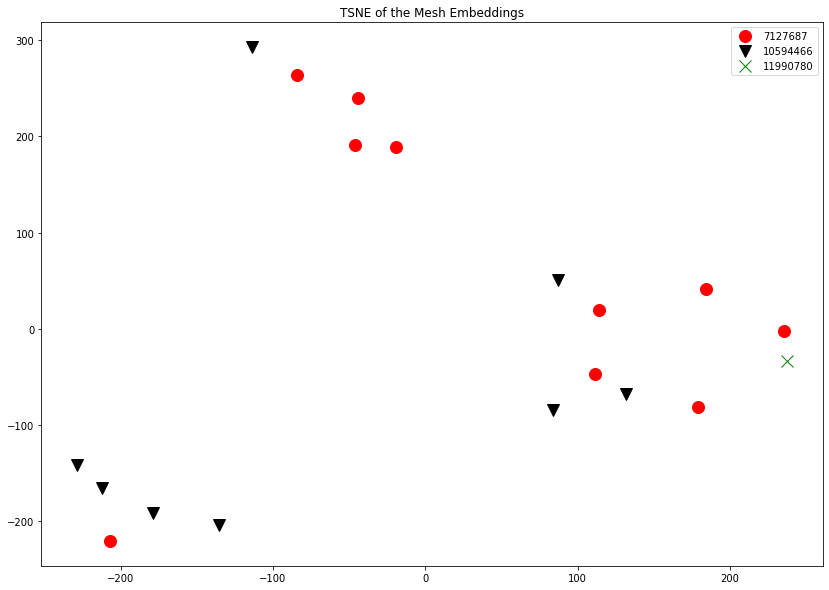

In [163]:
groups = output_testset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

## Visualize particular Use Cases
#### Mesh embeddings

In [275]:
mesh_cases = pd.read_csv('./data/mesh_data/mesh_paper_groups_pmid.csv')
typeA = mesh_cases['A']
typeB = mesh_cases['B']
df_a = pd.DataFrame((typeA,np.zeros((len(typeA),),dtype=int)),index=['pmid','class']).T
df_b = pd.DataFrame((typeB,np.ones((len(typeB),),dtype=int)),index=['pmid','class']).T
df_ab = pd.concat([df_a,df_b]).reset_index(drop=True)

In [276]:
df_ab.drop_duplicates(keep='first',inplace=True)

In [277]:
train_vae = train_set.__getvae__()
df_group = df[df['pmid'].isin(df_ab.pmid)]
group_run = ToyDS(df_group, df_group['last_author_name'].unique(),all_vae)
data =  torch.from_numpy(group_run.features).to(device,dtype=torch.float32)
optimizer.zero_grad()
recon_batch, mu, logvar= model(data)
bottle_neck = mu.cpu().detach().numpy()

Using pre-defined VAE FEATURES
Using old scaler
['MESH NAME NOT FOUND: SOS Response, Genetics', 'MESH NAME NOT FOUND: Phospholipid Hydroperoxide Glutathione Peroxidase', 'MESH NAME NOT FOUND: Indigenous Peoples', 'MESH NAME NOT FOUND: Inhibition, Psychological', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Formins', 'MESH NAME NOT FOUND: Male', 'MESH NAME NOT FOUND: RNA, Circular', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: Conditioning, Psychological', 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Reinforcement, Psychology', 'MESH NAME NOT FOUND: Female']


In [278]:
bottle_neck.shape

(199, 8)

In [279]:
labels = df_ab['class'].values
len(labels)

199

In [292]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=800,random_state=42)
tsne_results = tsne.fit_transform(bottle_neck)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 199 samples in 0.000s...
[t-SNE] Computed neighbors for 199 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 199 / 199
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.636292
[t-SNE] KL divergence after 800 iterations: 0.398583
t-SNE done! Time elapsed: 0.3286464214324951 seconds


In [293]:
df_subset=pd.DataFrame()
df_subset['tsne-2d-one'] = bottle_neck[:,0]
df_subset['tsne-2d-two'] = bottle_neck[:,1]
df_subset['class'] = labels

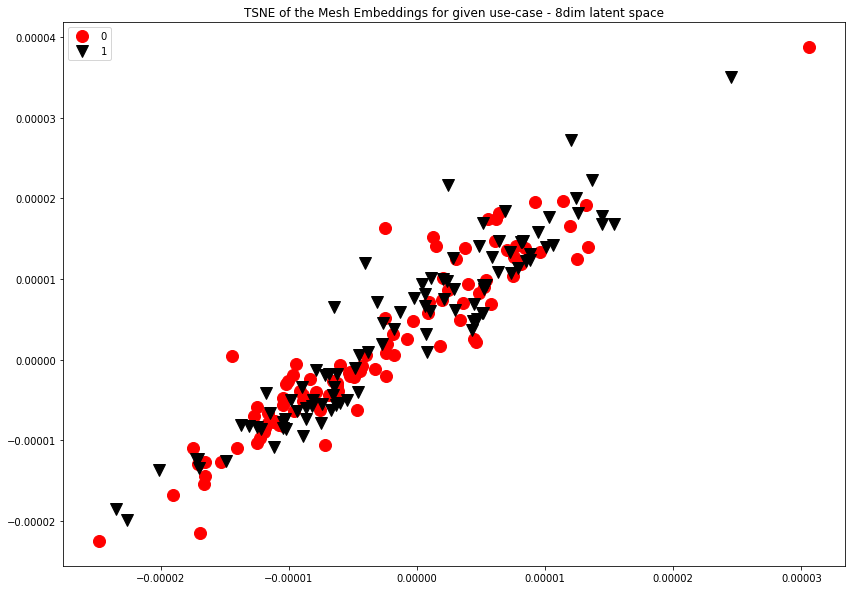

In [294]:
groups = df_subset.groupby('class')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings for given use-case - 8dim latent space")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/meshemb_2usecase_2dimls.png', bbox_inches='tight')